In [ ]:
import torch
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import torch.nn as nn
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
import io
import matplotlib.pyplot as plt
import numpy as np

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

torch.cuda.is_available()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# !pip install transformers

In [ ]:
df = pd.read_csv("data/preprocessed_sub_and_body.csv")
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)
df.head()

Unnamed: 0  label                                         text
0           0      0  fw: june 29 -- bna, inc. daily labor report
1           1      0                           ngx failover plan.
2           2      0                            re: intranet site
3           3      0         fw: ena upstream company information
4           4      0                          new master physical

In [ ]:
df["length"] = df["text"].apply(len)
df['length'].describe()

count    11448.000000
mean       891.971960
std       2101.099586
min          1.000000
25%         35.000000
50%         93.000000
75%        937.000000
max      29191.000000
Name: length, dtype: float64

In [ ]:
df.head()

Unnamed: 0  label                                         text  length
0           0      0  fw: june 29 -- bna, inc. daily labor report      43
1           1      0                           ngx failover plan.      18
2           2      0                            re: intranet site      17
3           3      0         fw: ena upstream company information      36
4           4      0                          new master physical      19

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

def plt_length():
  phishing_df = df[df["label"] == 1]
  ham_df = df[df["label"] == 0]

  _, ax = plt.subplots(figsize=(10, 4))
  sns.kdeplot(ham_df['length'], fill=True, label="Ham", color="b")
  sns.kdeplot(phishing_df['length'], fill=True, label="Phish", color="r")
  ax.set(
      xlabel="Length",
      ylabel="Density",
      title="Length of emails.",
  )
  ax.legend(loc="upper right")
  plt.show()

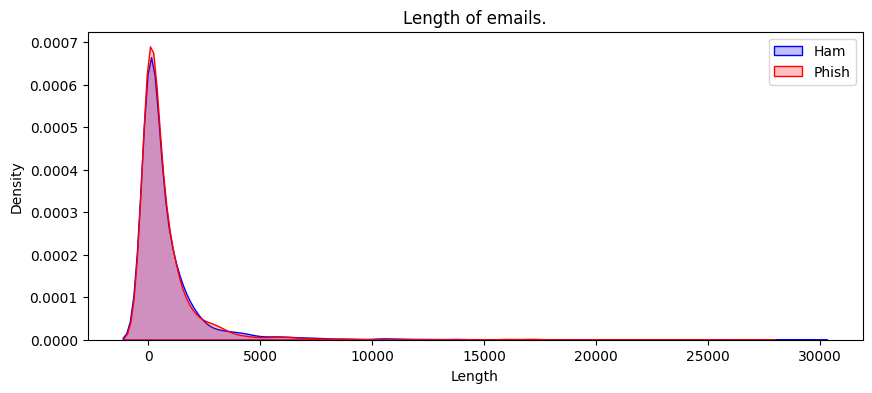

In [ ]:
plt_length()

In [ ]:
df['length'].describe()

count    11448.000000
mean       891.971960
std       2101.099586
min          1.000000
25%         35.000000
50%         93.000000
75%        937.000000
max      29191.000000
Name: length, dtype: float64

In [ ]:
!pip install torchtext==0.6.0

In [ ]:
from torchtext import data
from torchtext.vocab import Vocab
from collections import Counter
from nltk.tokenize import word_tokenize
import random

df = df[['text', 'label']]

df.to_csv("preprocessed_cleaned.csv", index=False)

TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', lower=True, include_lengths=True, batch_first=True)
LABEL = data.LabelField(dtype=torch.float, sequential=False, use_vocab=False, batch_first=True)

fields = [("body", TEXT), ("label", LABEL)]
dataset = data.TabularDataset(path="preprocessed_cleaned.csv", format="csv", fields=fields, skip_header=True)

train_data, val_data, test_data = dataset.split(split_ratio=[0.7, 0.1, 0.2], random_state=random.seed(42))

TEXT.build_vocab(train_data, max_size=10000, min_freq=5)


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


## Definisanje modela. 

Prije LSTM sloja je postavljen *Embedding* sloj kako bismo dobili dense vektore

Izlaz LSTM sloja se prosleđuje na Max pooling sloj.

*Dropout* slojevi su uključeni kako bi se sprečio overfitting nasumičnim deaktiviranjem dela neurona tokom treninga

Finalni sloj je Sigmoid aktivaciona funkcija pogodna za binarnu klasifikaciju

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, x_lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, x_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # apply global max pooling across the time dimension
        pooled_output = torch.max(output, dim=1)[0]

        pooled_output = self.dropout(pooled_output)
        fc_output = self.fc(pooled_output)
        output = self.sigmoid(fc_output)
        return output

In [ ]:
embedding_dims = [32, 64]
hidden_dims = [100, 128]
learning_rates = [0.01, 0.001]
batch_sizes = [64, 128]
dropout_rates = [0.3, 0.4]
n_epochs = 10

best_model = None
best_val_loss = float("inf")
results = []

In [ ]:
from tqdm.auto import tqdm
import itertools
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# grid search
for embedding_dim, hidden_dim, lr, batch_size, dropout1, dropout2 in itertools.product(
        embedding_dims, hidden_dims, learning_rates, batch_sizes, dropout_rates, dropout_rates):

      # create iterators
      train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
          (train_data, val_data, test_data),
          batch_size=batch_size,
          sort_key=lambda x: len(x.body),
          sort_within_batch=True, 
          device=device
      )


      lstm_model = LSTMModel(len(TEXT.vocab), embedding_dim, hidden_dim, 1, dropout2).to(device)
      criterion = nn.BCELoss()
      criterion = criterion.to(device)
      optimizer = optim.Adam(lstm_model.parameters(),lr=lr)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

      # early stopping criteria
      early_stopping_patience = 3
      best_epoch_val_loss = float('inf')
      epochs_no_improve = 0

      # TRAINING BLOCK
      train_losses = []
      val_losses = []

      for epoch in range(n_epochs):

          epoch_train_loss = 0
          lstm_model.train()

          with tqdm(train_iterator, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            for batch in tepoch:
                sequences, lengths = batch.body
                labels = batch.label
                optimizer.zero_grad()
                predictions = lstm_model(sequences, lengths).squeeze()
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

          train_losses.append(epoch_train_loss / len(train_iterator))

          print(f"\nTraining epoch {epoch + 1} loss: ", epoch_train_loss)
          # TRAINING BLOCK ENDS
          print("Training complete!")


          # Validation
          lstm_model.eval()
          epoch_val_loss = 0
          val_preds = []
          val_labels = []

          with torch.no_grad():
              for batch in val_iterator:
                  sequences, lengths = batch.body
                  labels = batch.label
                  predictions = lstm_model(sequences, lengths).squeeze()
                  loss = criterion(predictions, labels)
                  epoch_val_loss += loss.item()
                  val_preds.extend(predictions.cpu().numpy())
                  val_labels.extend(labels.cpu().numpy())

          val_losses.append(epoch_val_loss / len(val_iterator))

          print(f"\nValidation epoch {epoch + 1} loss: {epoch_val_loss}")

          # early stopping
          if epoch_val_loss < best_epoch_val_loss:
              best_epoch_val_loss = epoch_val_loss
              epochs_no_improve = 0
          else:
              epochs_no_improve += 1
              if epochs_no_improve >= early_stopping_patience:
                  print(f"Early stopping triggered at epoch {epoch+1}")
                  break

          # check if current model is the best
          if val_losses[-1] < best_val_loss:
              best_val_loss = val_losses[-1]
              best_model = lstm_model

          # record the results
          results.append({
              'embedding_dim': embedding_dim,
              'hidden_dim': hidden_dim,
              'lr': lr,
              'batch_size': batch_size,
              'dropout1': dropout1,
              'dropout2': dropout2,
              'n_epochs': n_epochs,
              'train_loss': train_losses[-1],
              'val_loss': val_losses[-1]
          })

best_hyperparams = min(results, key=lambda x: x['val_loss'])
print("Best Hyperparameters:")
print(best_hyperparams)


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  59.6718328371644
Training complete!

Validation epoch 1 loss: 5.105306506156921


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  27.025149391964078
Training complete!

Validation epoch 2 loss: 3.3170666061341763


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.570711622713134
Training complete!

Validation epoch 3 loss: 2.9582125432789326


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.347127670538612
Training complete!

Validation epoch 4 loss: 3.3378619933500886


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  7.1390334648313
Training complete!

Validation epoch 5 loss: 3.607156991958618


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.62500463143806
Training complete!

Validation epoch 6 loss: 3.8518090266152285
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  63.0254637748003
Training complete!

Validation epoch 1 loss: 5.3581866174936295


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  34.104072876274586
Training complete!

Validation epoch 2 loss: 3.88947045058012


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.799397103488445
Training complete!

Validation epoch 3 loss: 3.107235863804817


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.20062469691038
Training complete!

Validation epoch 4 loss: 3.1961712781339884


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  9.148667888483033
Training complete!

Validation epoch 5 loss: 3.1582427616231143


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  5.564316474541556
Training complete!

Validation epoch 6 loss: 3.4920550868846476
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  56.01252893358469
Training complete!

Validation epoch 1 loss: 3.9224013052880764


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  29.17316105775535
Training complete!

Validation epoch 2 loss: 3.3395706228911877


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.119795323349535
Training complete!

Validation epoch 3 loss: 2.7071064203046262


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  11.091306308284402
Training complete!

Validation epoch 4 loss: 2.8179059238173068


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  7.196053754189052
Training complete!

Validation epoch 5 loss: 2.9246324051637203


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.502005497226492
Training complete!

Validation epoch 6 loss: 3.399192621000111
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  60.1750520914793
Training complete!

Validation epoch 1 loss: 5.5063338577747345


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  28.27867090702057
Training complete!

Validation epoch 2 loss: 3.008110008202493


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  15.648253025487065
Training complete!

Validation epoch 3 loss: 2.606498352251947


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  14.550620146212168
Training complete!

Validation epoch 4 loss: 2.7935852641239762


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  7.806724797585048
Training complete!

Validation epoch 5 loss: 2.8090629694634117


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.441829069422965
Training complete!

Validation epoch 6 loss: 3.0721727678901516
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  37.77154615521431
Training complete!

Validation epoch 1 loss: 3.1709568947553635


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  16.21323160454631
Training complete!

Validation epoch 2 loss: 1.798193246126175


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.38334959000349
Training complete!

Validation epoch 3 loss: 1.5440287590026855


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.443422612734139
Training complete!

Validation epoch 4 loss: 1.5373289491981268


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.4028196630533785
Training complete!

Validation epoch 5 loss: 1.556545470841229


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.0946646945667453
Training complete!

Validation epoch 6 loss: 1.9785164650529623


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.9425670130876824
Training complete!

Validation epoch 7 loss: 1.9390033520758152
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.669019386172295
Training complete!

Validation epoch 1 loss: 2.7718959152698517


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.98242588341236
Training complete!

Validation epoch 2 loss: 2.6368584781885147


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.409126251935959
Training complete!

Validation epoch 3 loss: 2.067251540720463


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.291049733757973
Training complete!

Validation epoch 4 loss: 1.9765957072377205


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  9.465150821954012
Training complete!

Validation epoch 5 loss: 2.142294317483902


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  7.028930636122823
Training complete!

Validation epoch 6 loss: 2.0143102668225765


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.890016404911876
Training complete!

Validation epoch 7 loss: 1.874947004020214


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  4.046196925453842
Training complete!

Validation epoch 8 loss: 2.147929932922125


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  3.049368836451322
Training complete!

Validation epoch 9 loss: 2.0689494935795665


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  18.970967780798674
Training complete!

Validation epoch 10 loss: 1.7884436398744583


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  32.11277014017105
Training complete!

Validation epoch 1 loss: 2.3426387012004852


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  15.123159505426884
Training complete!

Validation epoch 2 loss: 2.3443733751773834


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.439579712226987
Training complete!

Validation epoch 3 loss: 1.4736246895045042


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.814317089505494
Training complete!

Validation epoch 4 loss: 1.424073874950409


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.782292417716235
Training complete!

Validation epoch 5 loss: 1.5477922959253192


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.278349998523481
Training complete!

Validation epoch 6 loss: 1.8024998400360346


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.8678440431831405
Training complete!

Validation epoch 7 loss: 1.7985862083733082
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  38.14982971549034
Training complete!

Validation epoch 1 loss: 3.116847574710846


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.047220185399055
Training complete!

Validation epoch 2 loss: 2.5835008174180984


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.117766194045544
Training complete!

Validation epoch 3 loss: 1.7614572942256927


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  10.570309782400727
Training complete!

Validation epoch 4 loss: 1.6570716202259064


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  7.940883791074157
Training complete!

Validation epoch 5 loss: 2.1455243453383446


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  5.159126627491787
Training complete!

Validation epoch 6 loss: 1.6329295337200165


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.705210813321173
Training complete!

Validation epoch 7 loss: 1.755758810788393


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  3.693741201655939
Training complete!

Validation epoch 8 loss: 1.9237528732046485


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  2.247065614326857
Training complete!

Validation epoch 9 loss: 1.8107724115252495
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  75.0543290823698
Training complete!

Validation epoch 1 loss: 7.141935467720032


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  59.5250785574317
Training complete!

Validation epoch 2 loss: 6.087790355086327


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  45.33345529064536
Training complete!

Validation epoch 3 loss: 5.217393092811108


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  39.809685446321964
Training complete!

Validation epoch 4 loss: 5.3806159645318985


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  33.724006954580545
Training complete!

Validation epoch 5 loss: 4.226629763841629


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  31.213185141794384
Training complete!

Validation epoch 6 loss: 6.823951035737991


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  30.975090995430946
Training complete!

Validation epoch 7 loss: 3.8083291202783585


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  25.779685062356293
Training complete!

Validation epoch 8 loss: 3.855493027716875


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  22.422084661200643
Training complete!

Validation epoch 9 loss: 3.968813855201006


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  23.183670709840953
Training complete!

Validation epoch 10 loss: 3.3067504800856113


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  78.83290469646454
Training complete!

Validation epoch 1 loss: 7.505096107721329


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  55.73558881878853
Training complete!

Validation epoch 2 loss: 6.503695383667946


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  50.19510282576084
Training complete!

Validation epoch 3 loss: 5.991650342941284


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  45.46606353670359
Training complete!

Validation epoch 4 loss: 5.612432226538658


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  40.256836861371994
Training complete!

Validation epoch 5 loss: 4.9400602132081985


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  35.83595260977745
Training complete!

Validation epoch 6 loss: 4.575236275792122


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  31.12866237014532
Training complete!

Validation epoch 7 loss: 4.386184096336365


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  31.151539912447333
Training complete!

Validation epoch 8 loss: 4.681062035262585


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  26.747941862791777
Training complete!

Validation epoch 9 loss: 4.2085338067263365


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  23.509934855625033
Training complete!

Validation epoch 10 loss: 3.7164479047060013


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  79.04175275564194
Training complete!

Validation epoch 1 loss: 6.950060814619064


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  56.42655588686466
Training complete!

Validation epoch 2 loss: 6.3368194699287415


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  55.64812768995762
Training complete!

Validation epoch 3 loss: 6.333182990550995


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  47.354504480957985
Training complete!

Validation epoch 4 loss: 5.495582386851311


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  44.776972986757755
Training complete!

Validation epoch 5 loss: 4.9261002987623215


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  33.84075838327408
Training complete!

Validation epoch 6 loss: 4.3011301308870316


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  29.48411724343896
Training complete!

Validation epoch 7 loss: 3.8983944058418274


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  26.23370160907507
Training complete!

Validation epoch 8 loss: 3.6795839741826057


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  24.150937545113266
Training complete!

Validation epoch 9 loss: 3.8698876053094864


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  24.60202206298709
Training complete!

Validation epoch 10 loss: 3.304759591817856


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  78.13369759917259
Training complete!

Validation epoch 1 loss: 7.197575032711029


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  53.686584778130054
Training complete!

Validation epoch 2 loss: 5.771532744169235


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  42.86002742499113
Training complete!

Validation epoch 3 loss: 4.953117363154888


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  36.348070876672864
Training complete!

Validation epoch 4 loss: 4.519352726638317


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  31.82944231107831
Training complete!

Validation epoch 5 loss: 3.907992262393236


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  26.392228316515684
Training complete!

Validation epoch 6 loss: 4.095541272312403


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  24.78895442187786
Training complete!

Validation epoch 7 loss: 3.444817181676626


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  22.777846850454807
Training complete!

Validation epoch 8 loss: 3.412535071372986


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  24.755365981720388
Training complete!

Validation epoch 9 loss: 3.22460915427655


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  17.378044556826353
Training complete!

Validation epoch 10 loss: 3.2386463843286037


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  42.33456099033356
Training complete!

Validation epoch 1 loss: 3.8956784307956696


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  27.76867352426052
Training complete!

Validation epoch 2 loss: 2.963876500725746


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  28.110835902392864
Training complete!

Validation epoch 3 loss: 3.6325471699237823


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  25.069408878684044
Training complete!

Validation epoch 4 loss: 3.0095743536949158


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  21.397679425776005
Training complete!

Validation epoch 5 loss: 2.530748873949051


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  18.53727263957262
Training complete!

Validation epoch 6 loss: 2.3922377303242683


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  20.491934835910797
Training complete!

Validation epoch 7 loss: 2.367333695292473


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  17.506344094872475
Training complete!

Validation epoch 8 loss: 2.3043977171182632


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  15.899168509989977
Training complete!

Validation epoch 9 loss: 2.2107747308909893


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.857967983931303
Training complete!

Validation epoch 10 loss: 1.9428940191864967


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  43.23985677957535
Training complete!

Validation epoch 1 loss: 4.463866502046585


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  31.58646348118782
Training complete!

Validation epoch 2 loss: 3.86994868516922


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  27.942705363035202
Training complete!

Validation epoch 3 loss: 2.9905216991901398


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  23.006652928888798
Training complete!

Validation epoch 4 loss: 2.5654310509562492


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  20.828166536986828
Training complete!

Validation epoch 5 loss: 2.5102363377809525


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  18.81340155750513
Training complete!

Validation epoch 6 loss: 2.340759463608265


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  16.974037744104862
Training complete!

Validation epoch 7 loss: 2.16972728818655


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  15.678554315119982
Training complete!

Validation epoch 8 loss: 2.0448125563561916


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  14.665507681667805
Training complete!

Validation epoch 9 loss: 1.9408841989934444


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  13.5911271777004
Training complete!

Validation epoch 10 loss: 2.1223642751574516


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  44.73942309617996
Training complete!

Validation epoch 1 loss: 5.012067466974258


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  32.03118874132633
Training complete!

Validation epoch 2 loss: 3.1855130195617676


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  25.65788272023201
Training complete!

Validation epoch 3 loss: 2.7965271323919296


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  21.568674989044666
Training complete!

Validation epoch 4 loss: 2.629718601703644


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  21.038582354784012
Training complete!

Validation epoch 5 loss: 2.4204201623797417


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  18.432427778840065
Training complete!

Validation epoch 6 loss: 2.1468700021505356


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  16.585671789944172
Training complete!

Validation epoch 7 loss: 2.0018753558397293


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.87192158959806
Training complete!

Validation epoch 8 loss: 2.095591679215431


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  14.548242827877402
Training complete!

Validation epoch 9 loss: 1.7692237831652164


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  12.523024595342577
Training complete!

Validation epoch 10 loss: 1.7672376856207848


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  45.86270499229431
Training complete!

Validation epoch 1 loss: 4.550750434398651


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  31.29839624464512
Training complete!

Validation epoch 2 loss: 3.297922983765602


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.28585122525692
Training complete!

Validation epoch 3 loss: 2.945162132382393


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  24.006099715828896
Training complete!

Validation epoch 4 loss: 2.8371586054563522


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  21.206532917916775
Training complete!

Validation epoch 5 loss: 2.509150207042694


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.16437041759491
Training complete!

Validation epoch 6 loss: 2.8018991500139236


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  19.589975610375404
Training complete!

Validation epoch 7 loss: 2.5098327174782753


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  17.29945231974125
Training complete!

Validation epoch 8 loss: 2.33282907307148


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  15.972541958093643
Training complete!

Validation epoch 9 loss: 2.0633667334914207


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.674369037151337
Training complete!

Validation epoch 10 loss: 2.4058780670166016


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  50.358288519084454
Training complete!

Validation epoch 1 loss: 4.759684219956398


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  22.170853967778385
Training complete!

Validation epoch 2 loss: 2.6523853819817305


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.239393980707973
Training complete!

Validation epoch 3 loss: 2.504395956173539


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.628970236168243
Training complete!

Validation epoch 4 loss: 3.2089607315137982


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.449786858371226
Training complete!

Validation epoch 5 loss: 3.4176125694066286


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.0646359806269174
Training complete!

Validation epoch 6 loss: 4.415691276779398
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  53.1213213801384
Training complete!

Validation epoch 1 loss: 4.532169476151466


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.87779150158167
Training complete!

Validation epoch 2 loss: 3.1465995591133833


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.193422015290707
Training complete!

Validation epoch 3 loss: 2.6523200049996376


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.663372523034923
Training complete!

Validation epoch 4 loss: 3.1644631195813417


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.4273982106824405
Training complete!

Validation epoch 5 loss: 3.6645853854715824


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.8312980157643324
Training complete!

Validation epoch 6 loss: 3.865833731368184
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  51.6705337613821
Training complete!

Validation epoch 1 loss: 3.871800761669874


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  24.543709749355912
Training complete!

Validation epoch 2 loss: 2.5547566628083587


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  10.71230678865686
Training complete!

Validation epoch 3 loss: 2.3938668495975435


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.99806113622617
Training complete!

Validation epoch 4 loss: 3.0932046063244343


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.463712492026389
Training complete!

Validation epoch 5 loss: 2.6262848108890466


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.4077814047050197
Training complete!

Validation epoch 6 loss: 2.9207207984291017
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  57.80993681401014
Training complete!

Validation epoch 1 loss: 3.703184053301811


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.708493097685277
Training complete!

Validation epoch 2 loss: 3.1162682864814997


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.365825994871557
Training complete!

Validation epoch 3 loss: 2.284563147695735


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  13.81587832479272
Training complete!

Validation epoch 4 loss: 2.3960490375757217


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.472620872082189
Training complete!

Validation epoch 5 loss: 2.842059147893451


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.942820289405063
Training complete!

Validation epoch 6 loss: 2.8485866354312748
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  33.9957754611969
Training complete!

Validation epoch 1 loss: 2.7580107748508453


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.006496362388134
Training complete!

Validation epoch 2 loss: 2.4985092878341675


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.245117085054517
Training complete!

Validation epoch 3 loss: 1.8313940688967705


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.070840077474713
Training complete!

Validation epoch 4 loss: 1.5652187168598175


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.47183005977422
Training complete!

Validation epoch 5 loss: 1.6951786540448666


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.4792410088703036
Training complete!

Validation epoch 6 loss: 1.7565662860870361


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.2682631496572867
Training complete!

Validation epoch 7 loss: 1.6865014298819005
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.9145325422287
Training complete!

Validation epoch 1 loss: 3.6508611738681793


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.59902962297201
Training complete!

Validation epoch 2 loss: 1.940965548157692


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  10.74562269449234
Training complete!

Validation epoch 3 loss: 1.7797891981899738


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.615215728059411
Training complete!

Validation epoch 4 loss: 1.7883158586919308


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.012347270618193
Training complete!

Validation epoch 5 loss: 2.120118573307991


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.8907086327672005
Training complete!

Validation epoch 6 loss: 2.1933272443711758
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.65615752339363
Training complete!

Validation epoch 1 loss: 3.127763643860817


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  18.612338066101074
Training complete!

Validation epoch 2 loss: 2.0407922193408012


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.432234112173319
Training complete!

Validation epoch 3 loss: 2.244215965270996


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.47833889350295
Training complete!

Validation epoch 4 loss: 1.7489720694720745


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.3262269757688046
Training complete!

Validation epoch 5 loss: 1.6409149505198002


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.397631524596363
Training complete!

Validation epoch 6 loss: 1.6563265956938267


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.836655362509191
Training complete!

Validation epoch 7 loss: 1.9814101215451956


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  1.7064751189318486
Training complete!

Validation epoch 8 loss: 2.015489931218326
Early stopping triggered at epoch 8


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.47983509302139
Training complete!

Validation epoch 1 loss: 2.4530788362026215


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  17.753270365297794
Training complete!

Validation epoch 2 loss: 2.0002113431692123


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.029558150097728
Training complete!

Validation epoch 3 loss: 1.4640408903360367


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.411069871392101
Training complete!

Validation epoch 4 loss: 1.2048016507178545


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.056649088393897
Training complete!

Validation epoch 5 loss: 1.3123105899430811


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.6669871443882585
Training complete!

Validation epoch 6 loss: 1.3507658820599318


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.9721434722014237
Training complete!

Validation epoch 7 loss: 1.358295296318829
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  77.24788551032543
Training complete!

Validation epoch 1 loss: 6.370376408100128


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  51.257324919104576
Training complete!

Validation epoch 2 loss: 5.345097176730633


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  39.16827589832246
Training complete!

Validation epoch 3 loss: 4.460656955838203


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  31.03941708803177
Training complete!

Validation epoch 4 loss: 3.991373483091593


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  26.229882415384054
Training complete!

Validation epoch 5 loss: 3.6484879553318024


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  23.553105337545276
Training complete!

Validation epoch 6 loss: 3.4960066014900804


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  20.72508043097332
Training complete!

Validation epoch 7 loss: 3.3770179972052574


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  19.986888713669032
Training complete!

Validation epoch 8 loss: 3.401072634384036


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  17.905810149386525
Training complete!

Validation epoch 9 loss: 3.217072729021311


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.834201189689338
Training complete!

Validation epoch 10 loss: 3.2151578571647406


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  77.12894035875797
Training complete!

Validation epoch 1 loss: 10.56090646982193


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  60.639855206012726
Training complete!

Validation epoch 2 loss: 6.774006932973862


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  58.86499996483326
Training complete!

Validation epoch 3 loss: 6.472217097878456


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  49.10558667778969
Training complete!

Validation epoch 4 loss: 5.388829335570335


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  41.69364885240793
Training complete!

Validation epoch 5 loss: 5.016464799642563


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  36.35472462326288
Training complete!

Validation epoch 6 loss: 4.247497923672199


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  34.420144990086555
Training complete!

Validation epoch 7 loss: 4.631254628300667


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  30.273923225700855
Training complete!

Validation epoch 8 loss: 4.0470066368579865


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  26.28370414674282
Training complete!

Validation epoch 9 loss: 3.6749771367758512


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  27.370422115549445
Training complete!

Validation epoch 10 loss: 5.154710005968809


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  75.57683962583542
Training complete!

Validation epoch 1 loss: 6.220371410250664


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  48.47412306070328
Training complete!

Validation epoch 2 loss: 5.010792873799801


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  38.962970316410065
Training complete!

Validation epoch 3 loss: 4.572818949818611


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  34.28782919142395
Training complete!

Validation epoch 4 loss: 4.079409904778004


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  29.54078746214509
Training complete!

Validation epoch 5 loss: 3.9795783050358295


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  25.08172072842717
Training complete!

Validation epoch 6 loss: 3.4388452395796776


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  20.524496785365045
Training complete!

Validation epoch 7 loss: 3.420424467418343


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  18.490191481541842
Training complete!

Validation epoch 8 loss: 3.185528243891895


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  16.56432577734813
Training complete!

Validation epoch 9 loss: 3.254910180810839


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.67106919689104
Training complete!

Validation epoch 10 loss: 3.0460879025049508


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  78.59018531441689
Training complete!

Validation epoch 1 loss: 7.367160394787788


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  55.96951302886009
Training complete!

Validation epoch 2 loss: 5.755807086825371


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  43.89817117899656
Training complete!

Validation epoch 3 loss: 4.899695470929146


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  36.801653444767
Training complete!

Validation epoch 4 loss: 4.250338073819876


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  32.54552474990487
Training complete!

Validation epoch 5 loss: 4.009256154298782


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  28.538620539940894
Training complete!

Validation epoch 6 loss: 3.562611497938633


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  24.585585217922926
Training complete!

Validation epoch 7 loss: 3.445232205092907


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  22.18790211249143
Training complete!

Validation epoch 8 loss: 3.197944052517414


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  18.97682168195024
Training complete!

Validation epoch 9 loss: 3.3255790662951767


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  17.442826330661774
Training complete!

Validation epoch 10 loss: 3.0877842851914465


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  43.76869207620621
Training complete!

Validation epoch 1 loss: 4.740838795900345


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  31.648864328861237
Training complete!

Validation epoch 2 loss: 3.230158194899559


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.16066062450409
Training complete!

Validation epoch 3 loss: 2.585461214184761


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.68317198753357
Training complete!

Validation epoch 4 loss: 2.326694257557392


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  17.76288900524378
Training complete!

Validation epoch 5 loss: 2.1866684034466743


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  16.159838803112507
Training complete!

Validation epoch 6 loss: 2.1707525849342346


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  15.719480857253075
Training complete!

Validation epoch 7 loss: 2.003751426935196


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  13.148232240229845
Training complete!

Validation epoch 8 loss: 1.7808125913143158


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  12.221733409911394
Training complete!

Validation epoch 9 loss: 1.7660499140620232


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  10.84374629613012
Training complete!

Validation epoch 10 loss: 1.656862460076809


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  43.5488997399807
Training complete!

Validation epoch 1 loss: 4.666697263717651


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  30.356704652309418
Training complete!

Validation epoch 2 loss: 3.004849821329117


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  25.606676042079926
Training complete!

Validation epoch 3 loss: 2.693544402718544


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  23.04609091579914
Training complete!

Validation epoch 4 loss: 2.580184981226921


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  19.162451557815075
Training complete!

Validation epoch 5 loss: 2.3322028890252113


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  17.900180242955685
Training complete!

Validation epoch 6 loss: 2.5737694427371025


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  16.930866062641144
Training complete!

Validation epoch 7 loss: 2.0685615241527557


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.29739025235176
Training complete!

Validation epoch 8 loss: 1.9292294830083847


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  13.22642619162798
Training complete!

Validation epoch 9 loss: 1.8098617196083069


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  11.99620215408504
Training complete!

Validation epoch 10 loss: 2.9396992325782776


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  44.09186527132988
Training complete!

Validation epoch 1 loss: 4.49011904001236


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  33.02302673459053
Training complete!

Validation epoch 2 loss: 3.5920047760009766


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  29.55301459133625
Training complete!

Validation epoch 3 loss: 3.326000601053238


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  25.927212715148926
Training complete!

Validation epoch 4 loss: 3.0093331038951874


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  22.61792367696762
Training complete!

Validation epoch 5 loss: 2.9148195534944534


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.84166381508112
Training complete!

Validation epoch 6 loss: 2.735840931534767


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  19.119572915136814
Training complete!

Validation epoch 7 loss: 2.3237136602401733


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  18.222554702311754
Training complete!

Validation epoch 8 loss: 3.997962325811386


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  20.47566868364811
Training complete!

Validation epoch 9 loss: 2.1198250204324722


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.790890004485846
Training complete!

Validation epoch 10 loss: 1.8667651936411858


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  42.275198578834534
Training complete!

Validation epoch 1 loss: 3.8872492611408234


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  28.843340501189232
Training complete!

Validation epoch 2 loss: 3.7667656540870667


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  25.064107172191143
Training complete!

Validation epoch 3 loss: 2.807215631008148


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  20.162986554205418
Training complete!

Validation epoch 4 loss: 2.5065323933959007


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  18.230262979865074
Training complete!

Validation epoch 5 loss: 2.4017306864261627


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  17.25608754903078
Training complete!

Validation epoch 6 loss: 2.3813759982585907


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  17.11890348792076
Training complete!

Validation epoch 7 loss: 2.1990008652210236


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.16116926446557
Training complete!

Validation epoch 8 loss: 2.0473229587078094


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  12.426843658089638
Training complete!

Validation epoch 9 loss: 1.9361204877495766


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  11.250236067920923
Training complete!

Validation epoch 10 loss: 1.8962159417569637


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  53.71489657461643
Training complete!

Validation epoch 1 loss: 4.209130942821503


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.341395024210215
Training complete!

Validation epoch 2 loss: 2.8842093367129564


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.980262727476656
Training complete!

Validation epoch 3 loss: 2.7334728483110666


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.010095208650455
Training complete!

Validation epoch 4 loss: 2.6338994093239307


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.971167929354124
Training complete!

Validation epoch 5 loss: 3.599163005128503


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.692323245515581
Training complete!

Validation epoch 6 loss: 3.2286089845001698


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.0578955165983643
Training complete!

Validation epoch 7 loss: 5.716089498717338
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  46.54807870090008
Training complete!

Validation epoch 1 loss: 3.9105178751051426


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.889652222394943
Training complete!

Validation epoch 2 loss: 2.978502031415701


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  10.494087013648823
Training complete!

Validation epoch 3 loss: 3.0104239424690604


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.459591684339102
Training complete!

Validation epoch 4 loss: 3.645937353372574


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  7.18042072597018
Training complete!

Validation epoch 5 loss: 3.752043823245913
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  50.54574428871274
Training complete!

Validation epoch 1 loss: 3.516000870615244


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.08330910280347
Training complete!

Validation epoch 2 loss: 2.6175683941692114


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.241269212856423
Training complete!

Validation epoch 3 loss: 2.727140814997256


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.399300659250002
Training complete!

Validation epoch 4 loss: 3.50550282234326


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.9904465607833117
Training complete!

Validation epoch 5 loss: 3.899554359377362
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  51.493352979421616
Training complete!

Validation epoch 1 loss: 3.474673166871071


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.43901344574988
Training complete!

Validation epoch 2 loss: 2.5725003331899643


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  10.769199312198907
Training complete!

Validation epoch 3 loss: 2.322874083649367


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  10.288438195362687
Training complete!

Validation epoch 4 loss: 3.2769269244745374


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.718602677967283
Training complete!

Validation epoch 5 loss: 2.807097681798041


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.234181026782608
Training complete!

Validation epoch 6 loss: 3.0404520861338824
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  29.282306730747223
Training complete!

Validation epoch 1 loss: 2.2588970214128494


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.835255354642868
Training complete!

Validation epoch 2 loss: 1.5622159130871296


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  10.291521163657308
Training complete!

Validation epoch 3 loss: 1.5097934268414974


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.260121710598469
Training complete!

Validation epoch 4 loss: 1.3577068876475096


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.1745269468519837
Training complete!

Validation epoch 5 loss: 1.5022441912442446


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.075197692203801
Training complete!

Validation epoch 6 loss: 1.7354983622208238


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.5257519608712755
Training complete!

Validation epoch 7 loss: 1.8171398658305407
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.61285084486008
Training complete!

Validation epoch 1 loss: 2.7664623260498047


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  25.3395756483078
Training complete!

Validation epoch 2 loss: 2.7300714552402496


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  17.711291439831257
Training complete!

Validation epoch 3 loss: 2.326772391796112


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  13.191531505435705
Training complete!

Validation epoch 4 loss: 2.135686442255974


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.57315556704998
Training complete!

Validation epoch 5 loss: 1.9369568787515163


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.133220614865422
Training complete!

Validation epoch 6 loss: 1.9586233347654343


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.864959893748164
Training complete!

Validation epoch 7 loss: 1.925825184211135


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.579576909542084
Training complete!

Validation epoch 8 loss: 1.9061121940612793


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.499923613853753
Training complete!

Validation epoch 9 loss: 2.030603189021349


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  3.37508280063048
Training complete!

Validation epoch 10 loss: 2.0885272100567818


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  28.43806041777134
Training complete!

Validation epoch 1 loss: 1.9317200407385826


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.976342592388391
Training complete!

Validation epoch 2 loss: 1.8082020804286003


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.652979597449303
Training complete!

Validation epoch 3 loss: 1.461817566305399


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.750287152361125
Training complete!

Validation epoch 4 loss: 1.4268082529306412


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.8706500087864697
Training complete!

Validation epoch 5 loss: 1.598326338455081


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.3804943144787103
Training complete!

Validation epoch 6 loss: 1.694884991273284


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.5753943905001506
Training complete!

Validation epoch 7 loss: 1.9774590656161308
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  28.992939427495003
Training complete!

Validation epoch 1 loss: 2.1659699603915215


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.869608491659164
Training complete!

Validation epoch 2 loss: 2.003972440958023


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.124531291425228
Training complete!

Validation epoch 3 loss: 1.466377703472972


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.83364845206961
Training complete!

Validation epoch 4 loss: 1.7689547538757324


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.211146552348509
Training complete!

Validation epoch 5 loss: 1.7414552997797728


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.7429390294710174
Training complete!

Validation epoch 6 loss: 1.683090896345675
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  69.01963728666306
Training complete!

Validation epoch 1 loss: 5.6550193428993225


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  44.28768736124039
Training complete!

Validation epoch 2 loss: 4.7759527042508125


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  34.221308978274465
Training complete!

Validation epoch 3 loss: 4.155653342604637


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  28.91473974380642
Training complete!

Validation epoch 4 loss: 3.828334104269743


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  23.761000010184944
Training complete!

Validation epoch 5 loss: 3.6596344634890556


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.36976980883628
Training complete!

Validation epoch 6 loss: 3.3678851993754506


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  20.799942481331527
Training complete!

Validation epoch 7 loss: 3.7345292419195175


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  15.858230888843536
Training complete!

Validation epoch 8 loss: 3.111921740230173


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  12.193451780127361
Training complete!

Validation epoch 9 loss: 3.3241600315086544


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  10.774807929294184
Training complete!

Validation epoch 10 loss: 3.522310589440167


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  70.85245586931705
Training complete!

Validation epoch 1 loss: 6.200312525033951


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  45.216756939888
Training complete!

Validation epoch 2 loss: 5.037816271185875


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  44.857800520956516
Training complete!

Validation epoch 3 loss: 5.191302061080933


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  36.817444175481796
Training complete!

Validation epoch 4 loss: 4.290807906538248


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  30.959931146353483
Training complete!

Validation epoch 5 loss: 4.175516992807388


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  26.50351414270699
Training complete!

Validation epoch 6 loss: 3.864499818533659


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  25.05662666633725
Training complete!

Validation epoch 7 loss: 3.737069372087717


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  20.136503922753036
Training complete!

Validation epoch 8 loss: 3.8934421306475997


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  22.921281137503684
Training complete!

Validation epoch 9 loss: 5.013221919536591


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  22.898386931046844
Training complete!

Validation epoch 10 loss: 3.773580141365528
Early stopping triggered at epoch 10


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  70.95411956310272
Training complete!

Validation epoch 1 loss: 6.042880594730377


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  46.61879049241543
Training complete!

Validation epoch 2 loss: 4.820891819894314


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  40.86243123561144
Training complete!

Validation epoch 3 loss: 4.339022479951382


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  30.92211622465402
Training complete!

Validation epoch 4 loss: 3.608358144760132


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  25.00639291945845
Training complete!

Validation epoch 5 loss: 3.2300927564501762


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  27.1384059288539
Training complete!

Validation epoch 6 loss: 3.5727977864444256


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  20.487648976035416
Training complete!

Validation epoch 7 loss: 2.947667082771659


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  16.40623094793409
Training complete!

Validation epoch 8 loss: 2.9093862511217594


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  22.345251352293417
Training complete!

Validation epoch 9 loss: 5.890582740306854


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  17.49998830165714
Training complete!

Validation epoch 10 loss: 3.0457776933908463


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  74.66058120131493
Training complete!

Validation epoch 1 loss: 6.682379722595215


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  50.80714267492294
Training complete!

Validation epoch 2 loss: 5.3359761238098145


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  40.26180285215378
Training complete!

Validation epoch 3 loss: 4.620788410305977


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  34.23599665425718
Training complete!

Validation epoch 4 loss: 4.091199405491352


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  28.91176670975983
Training complete!

Validation epoch 5 loss: 4.048613399267197


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  24.548588179051876
Training complete!

Validation epoch 6 loss: 3.442511174827814


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  26.064129054546356
Training complete!

Validation epoch 7 loss: 3.2501299530267715


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  22.585149178281426
Training complete!

Validation epoch 8 loss: 3.066029831767082


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  17.091307875234634
Training complete!

Validation epoch 9 loss: 3.026157733052969


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.118991576135159
Training complete!

Validation epoch 10 loss: 2.8291360242292285


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  41.45089590549469
Training complete!

Validation epoch 1 loss: 4.348899841308594


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.124397829174995
Training complete!

Validation epoch 2 loss: 2.6206292808055878


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  22.296626083552837
Training complete!

Validation epoch 3 loss: 4.016029596328735


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.989042155444622
Training complete!

Validation epoch 4 loss: 2.2682134062051773


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.90308988839388
Training complete!

Validation epoch 5 loss: 2.0966056436300278


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.68454910069704
Training complete!

Validation epoch 6 loss: 1.9409690350294113


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.707552172243595
Training complete!

Validation epoch 7 loss: 1.8402769714593887


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.503773260861635
Training complete!

Validation epoch 8 loss: 1.8834877721965313


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  10.186944106593728
Training complete!

Validation epoch 9 loss: 1.7842028439044952


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.917165258899331
Training complete!

Validation epoch 10 loss: 1.607217825949192


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  41.237351447343826
Training complete!

Validation epoch 1 loss: 4.300703763961792


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.46177849173546
Training complete!

Validation epoch 2 loss: 2.854864463210106


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.66586459428072
Training complete!

Validation epoch 3 loss: 2.3399132788181305


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  18.59989357739687
Training complete!

Validation epoch 4 loss: 2.2544660046696663


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.2512240819633
Training complete!

Validation epoch 5 loss: 1.968982145190239


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.074285760521889
Training complete!

Validation epoch 6 loss: 1.8708495572209358


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.961682019755244
Training complete!

Validation epoch 7 loss: 1.8997676819562912


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.648112021386623
Training complete!

Validation epoch 8 loss: 1.7038067430257797


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.952828361652792
Training complete!

Validation epoch 9 loss: 1.6090341210365295


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.509055187925696
Training complete!

Validation epoch 10 loss: 1.624431848526001


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  41.16004920005798
Training complete!

Validation epoch 1 loss: 3.778609812259674


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.18981623649597
Training complete!

Validation epoch 2 loss: 3.0049515813589096


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  22.567522779107094
Training complete!

Validation epoch 3 loss: 2.6740287095308304


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  18.91883136704564
Training complete!

Validation epoch 4 loss: 2.3097637444734573


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.407036807388067
Training complete!

Validation epoch 5 loss: 2.111796721816063


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.517872992902994
Training complete!

Validation epoch 6 loss: 1.995137058198452


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.23574639763683
Training complete!

Validation epoch 7 loss: 1.8827132657170296


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.580003704875708
Training complete!

Validation epoch 8 loss: 1.777711259201169


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  10.522860327735543
Training complete!

Validation epoch 9 loss: 1.7081812024116516


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.101147173903883
Training complete!

Validation epoch 10 loss: 1.6535830646753311


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  41.70739242434502
Training complete!

Validation epoch 1 loss: 4.572731971740723


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  28.327748730778694
Training complete!

Validation epoch 2 loss: 3.084004506468773


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  23.099517434835434
Training complete!

Validation epoch 3 loss: 2.7106585800647736


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.34957902878523
Training complete!

Validation epoch 4 loss: 2.313363254070282


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.562179043889046
Training complete!

Validation epoch 5 loss: 2.1350240111351013


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  15.142732959240675
Training complete!

Validation epoch 6 loss: 2.047583270817995


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.00793670117855
Training complete!

Validation epoch 7 loss: 2.031617432832718


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  13.163581851869822
Training complete!

Validation epoch 8 loss: 1.8393892496824265


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  11.742265367880464
Training complete!

Validation epoch 9 loss: 1.7594955377280712


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  10.16941205598414
Training complete!

Validation epoch 10 loss: 1.6763897370547056


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  47.93213700503111
Training complete!

Validation epoch 1 loss: 3.408646546304226


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.321073357015848
Training complete!

Validation epoch 2 loss: 2.7528382828459144


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.84074673615396
Training complete!

Validation epoch 3 loss: 3.12170592462644


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.211380905646365
Training complete!

Validation epoch 4 loss: 3.13275858014822


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.271785378936329
Training complete!

Validation epoch 5 loss: 3.5418692249804735
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  56.66339376568794
Training complete!

Validation epoch 1 loss: 4.428034506738186


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.29562975652516
Training complete!

Validation epoch 2 loss: 3.961713545024395


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  17.071109478361905
Training complete!

Validation epoch 3 loss: 2.6191658657044172


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.88932371721603
Training complete!

Validation epoch 4 loss: 2.785231845919043


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.967598971066764
Training complete!

Validation epoch 5 loss: 3.469033748609945


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.336429248280183
Training complete!

Validation epoch 6 loss: 4.010771399363875
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  54.82555727660656
Training complete!

Validation epoch 1 loss: 3.802974820137024


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  22.814973585307598
Training complete!

Validation epoch 2 loss: 2.8058681674301624


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  10.639393154997379
Training complete!

Validation epoch 3 loss: 2.678025349508971


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.833837643265724
Training complete!

Validation epoch 4 loss: 3.401028471067548


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.765977864648448
Training complete!

Validation epoch 5 loss: 3.438641211600043


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.6296831886138534
Training complete!

Validation epoch 6 loss: 3.400263577030273
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  53.41005974262953
Training complete!

Validation epoch 1 loss: 3.651866927742958


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.972818311303854
Training complete!

Validation epoch 2 loss: 3.0413932632654905


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.690068984869868
Training complete!

Validation epoch 3 loss: 2.8081935313530266


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.404740766971372
Training complete!

Validation epoch 4 loss: 3.335576035315171


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.131990797410253
Training complete!

Validation epoch 5 loss: 3.8158277818001807


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.914810770424083
Training complete!

Validation epoch 6 loss: 4.301452587591484
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  31.633596122264862
Training complete!

Validation epoch 1 loss: 2.1347593665122986


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  13.870289729908109
Training complete!

Validation epoch 2 loss: 1.5569936521351337


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.3086700746789575
Training complete!

Validation epoch 3 loss: 1.4831917136907578


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.000066367443651
Training complete!

Validation epoch 4 loss: 1.4827491473406553


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.8086200580000877
Training complete!

Validation epoch 5 loss: 1.6437789760529995


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.9815077705716249
Training complete!

Validation epoch 6 loss: 1.8342096162959933


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.3421901925175916
Training complete!

Validation epoch 7 loss: 1.805834375321865
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  32.98858566582203
Training complete!

Validation epoch 1 loss: 2.5877956449985504


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  15.334721103310585
Training complete!

Validation epoch 2 loss: 1.5746689848601818


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.128250880166888
Training complete!

Validation epoch 3 loss: 1.4245682321488857


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.248209336772561
Training complete!

Validation epoch 4 loss: 1.424259215593338


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.0467633143998682
Training complete!

Validation epoch 5 loss: 1.7081236727535725


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.332608556258492
Training complete!

Validation epoch 6 loss: 1.7166524827480316


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.9242202482419088
Training complete!

Validation epoch 7 loss: 1.6228530236985534
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  29.36235398799181
Training complete!

Validation epoch 1 loss: 2.2131959199905396


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.726200982928276
Training complete!

Validation epoch 2 loss: 1.5260375142097473


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.786052134819329
Training complete!

Validation epoch 3 loss: 1.4590138643980026


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.9600491747260094
Training complete!

Validation epoch 4 loss: 1.4312208853662014


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.534920862177387
Training complete!

Validation epoch 5 loss: 1.7910550013184547


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.7962576383142732
Training complete!

Validation epoch 6 loss: 1.828508872538805


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.072313209064305
Training complete!

Validation epoch 7 loss: 1.6303838174790144
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  31.819258734583855
Training complete!

Validation epoch 1 loss: 3.0569982528686523


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  17.723671302199364
Training complete!

Validation epoch 2 loss: 1.8356570564210415


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.324165251106024
Training complete!

Validation epoch 3 loss: 1.5802242681384087


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.764150680974126
Training complete!

Validation epoch 4 loss: 1.623665351420641


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.6847142740152776
Training complete!

Validation epoch 5 loss: 1.6667711567133665


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.4866431527771056
Training complete!

Validation epoch 6 loss: 1.7193076200783253
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  73.2236425280571
Training complete!

Validation epoch 1 loss: 6.986999019980431


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  57.555396500974894
Training complete!

Validation epoch 2 loss: 6.349407345056534


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  42.74275003746152
Training complete!

Validation epoch 3 loss: 5.362816035747528


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  34.46015405654907
Training complete!

Validation epoch 4 loss: 4.237790077924728


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  28.6559574380517
Training complete!

Validation epoch 5 loss: 3.951355442404747


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  27.75321302190423
Training complete!

Validation epoch 6 loss: 3.6178830042481422


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  22.57153511699289
Training complete!

Validation epoch 7 loss: 3.6705722101032734


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  19.419351218268275
Training complete!

Validation epoch 8 loss: 3.35489366017282


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  16.987351941410452
Training complete!

Validation epoch 9 loss: 3.993569018319249


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  22.339062356972136
Training complete!

Validation epoch 10 loss: 3.884298510849476


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  72.93960645794868
Training complete!

Validation epoch 1 loss: 6.781247287988663


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  48.65789857506752
Training complete!

Validation epoch 2 loss: 5.201129198074341


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  37.43756162747741
Training complete!

Validation epoch 3 loss: 4.527269124984741


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  31.619970586150885
Training complete!

Validation epoch 4 loss: 4.114419978111982


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  26.18178112618625
Training complete!

Validation epoch 5 loss: 3.6052775718271732


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  28.074567455798388
Training complete!

Validation epoch 6 loss: 5.918631061911583


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  29.137046560645103
Training complete!

Validation epoch 7 loss: 3.6001794673502445


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  19.709574681706727
Training complete!

Validation epoch 8 loss: 4.082796171307564


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  17.618926350958645
Training complete!

Validation epoch 9 loss: 3.4535618983209133


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  16.184950980357826
Training complete!

Validation epoch 10 loss: 3.5743051506578922


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  69.91438423097134
Training complete!

Validation epoch 1 loss: 6.451516777276993


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  53.332160808146
Training complete!

Validation epoch 2 loss: 6.113299608230591


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  42.16814764589071
Training complete!

Validation epoch 3 loss: 4.817891821265221


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  33.76408962160349
Training complete!

Validation epoch 4 loss: 4.243530888110399


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  28.71664961054921
Training complete!

Validation epoch 5 loss: 4.2389498725533485


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  24.785379335284233
Training complete!

Validation epoch 6 loss: 4.156310360878706


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  23.13832389935851
Training complete!

Validation epoch 7 loss: 3.639423992484808


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  19.721548825502396
Training complete!

Validation epoch 8 loss: 3.749437600374222


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  21.271298611536622
Training complete!

Validation epoch 9 loss: 3.5128643848001957


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  16.036184635944664
Training complete!

Validation epoch 10 loss: 3.3197840647771955


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  70.89626121520996
Training complete!

Validation epoch 1 loss: 6.246198132634163


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  46.268179044127464
Training complete!

Validation epoch 2 loss: 5.099077090620995


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  39.72762141376734
Training complete!

Validation epoch 3 loss: 4.4436714723706245


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  31.965625699609518
Training complete!

Validation epoch 4 loss: 4.573467023670673


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  27.75921680033207
Training complete!

Validation epoch 5 loss: 3.931005947291851


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  24.103673143312335
Training complete!

Validation epoch 6 loss: 3.899667903780937


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  20.376958010252565
Training complete!

Validation epoch 7 loss: 3.5283672846853733


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  16.685942539013922
Training complete!

Validation epoch 8 loss: 3.4300894560292363


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  15.161376665579155
Training complete!

Validation epoch 9 loss: 3.6190699860453606


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.597783796489239
Training complete!

Validation epoch 10 loss: 3.453665357083082


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  40.08378890156746
Training complete!

Validation epoch 1 loss: 3.482593759894371


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  24.74692292511463
Training complete!

Validation epoch 2 loss: 2.638719826936722


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.143909744918346
Training complete!

Validation epoch 3 loss: 2.371911942958832


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  17.406950794160366
Training complete!

Validation epoch 4 loss: 2.10417577624321


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.629732470959425
Training complete!

Validation epoch 5 loss: 2.126839116215706


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.554843258112669
Training complete!

Validation epoch 6 loss: 2.044903516769409


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.626538451761007
Training complete!

Validation epoch 7 loss: 1.7065475136041641


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  10.223258859477937
Training complete!

Validation epoch 8 loss: 1.618181404657662


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  8.697214442305267
Training complete!

Validation epoch 9 loss: 1.54990414949134


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.037248430773616
Training complete!

Validation epoch 10 loss: 1.4707523435354233


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  39.6998770236969
Training complete!

Validation epoch 1 loss: 3.468870371580124


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  25.697137147188187
Training complete!

Validation epoch 2 loss: 2.5889633744955063


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  23.27813282608986
Training complete!

Validation epoch 3 loss: 2.602143630385399


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.64912946522236
Training complete!

Validation epoch 4 loss: 2.257683537900448


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.50642593204975
Training complete!

Validation epoch 5 loss: 1.963954322040081


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.58334699086845
Training complete!

Validation epoch 6 loss: 1.7885428294539452


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  14.023968312889338
Training complete!

Validation epoch 7 loss: 1.876860186457634


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.231087151914835
Training complete!

Validation epoch 8 loss: 1.6907688416540623


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.587477499619126
Training complete!

Validation epoch 9 loss: 1.5560825113207102


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.492426085751504
Training complete!

Validation epoch 10 loss: 1.5442512650042772


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  39.66373372077942
Training complete!

Validation epoch 1 loss: 3.8355849981307983


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  27.428360670804977
Training complete!

Validation epoch 2 loss: 2.8587107807397842


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.588519044220448
Training complete!

Validation epoch 3 loss: 2.435056358575821


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  18.53668599203229
Training complete!

Validation epoch 4 loss: 2.250848576426506


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.30647587776184
Training complete!

Validation epoch 5 loss: 2.233986049890518


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.121314134448767
Training complete!

Validation epoch 6 loss: 1.9249522909522057


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.225581116043031
Training complete!

Validation epoch 7 loss: 1.7356451004743576


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.189821230247617
Training complete!

Validation epoch 8 loss: 1.695455927401781


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  10.746030339039862
Training complete!

Validation epoch 9 loss: 1.668018363416195


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.454019040800631
Training complete!

Validation epoch 10 loss: 1.696914903819561


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  39.620161950588226
Training complete!

Validation epoch 1 loss: 3.3300125300884247


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  25.50306035578251
Training complete!

Validation epoch 2 loss: 2.662494048476219


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  22.81814542412758
Training complete!

Validation epoch 3 loss: 2.5261740908026695


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  20.016613848507404
Training complete!

Validation epoch 4 loss: 2.329325594007969


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  19.743983142077923
Training complete!

Validation epoch 5 loss: 2.29204298555851


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  15.159298364073038
Training complete!

Validation epoch 6 loss: 1.8421694412827492


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  14.151862438768148
Training complete!

Validation epoch 7 loss: 1.8252277001738548


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.687984239310026
Training complete!

Validation epoch 8 loss: 1.5812000185251236


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  10.155976606532931
Training complete!

Validation epoch 9 loss: 1.4808412455022335


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.93408412579447
Training complete!

Validation epoch 10 loss: 1.5027425065636635
Best Hyperparameters:
{'embedding_dim': 32, 'hidden_dim': 128, 'lr': 0.01, 'batch_size': 64, 'dropout1': 0.4, 'dropout2': 0.4, 'n_epochs': 10, 'train_loss': 0.08587379163105248, 'val_loss': 0.1269201748719853}


In [ ]:
model_save_path = "drive/MyDrive/lstm_torch_model.pt"
optimizer_save_path = "drive/MyDrive/lstm_torch_optimizer.pt"

torch.save(best_model.state_dict(), model_save_path)

torch.save(optimizer.state_dict(), optimizer_save_path)

print("Model and optimizer state saved successfully.")

Model and optimizer state saved successfully.


In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss for the best model
plt.figure(figsize=(10, 5))
plt.plot(range(1, best_hyperparams['n_epochs'] + 1), train_losses, label='Train Loss')
plt.plot(range(1, best_hyperparams['n_epochs'] + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
lstm_model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_iterator:
        sequences, lengths = batch.body
        labels = batch.label
        predictions = lstm_model(sequences, lengths).squeeze()
        test_preds.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


# convert to binary predictions
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# metrics
accuracy = accuracy_score(test_labels, test_preds_binary)
precision = precision_score(test_labels, test_preds_binary)
recall = recall_score(test_labels, test_preds_binary)
f1 = f1_score(test_labels, test_preds_binary)
roc_auc = roc_auc_score(test_labels, test_preds)

#  confusion matrix
cm = confusion_matrix(test_labels, test_preds_binary)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Test Precision: {precision*100:.2f}%')
print(f'Test Recall: {recall*100:.2f}%')
print(f'Test F1 Score: {f1*100:.2f}%')
print(f'Test ROC AUC: {roc_auc*100:.2f}%')
print(f'False Positive Rate: {fpr*100:.2f}%')
print(f'False Negative Rate: {fnr*100:.2f}%')

Test Accuracy: 92.75%
Test Precision: 93.17%
Test Recall: 92.36%
Test F1 Score: 92.76%
Test ROC AUC: 98.11%
False Positive Rate: 6.85%
False Negative Rate: 7.64%
